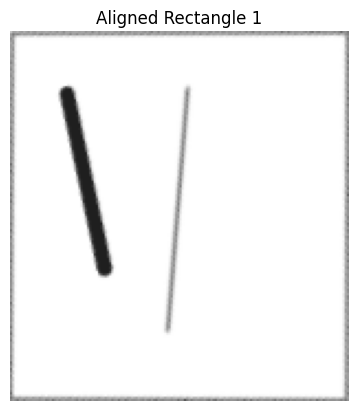

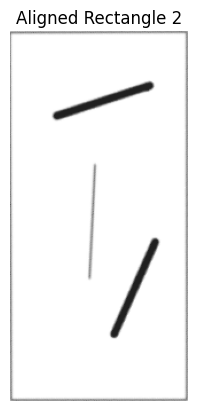

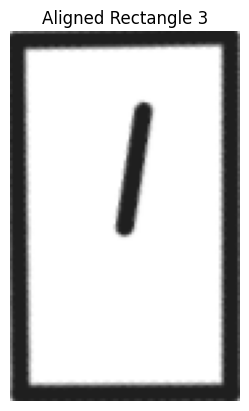

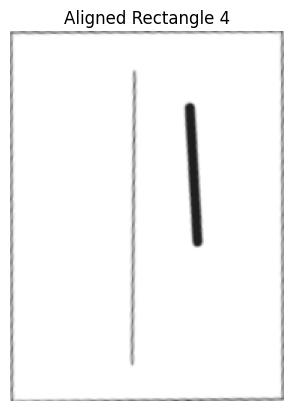

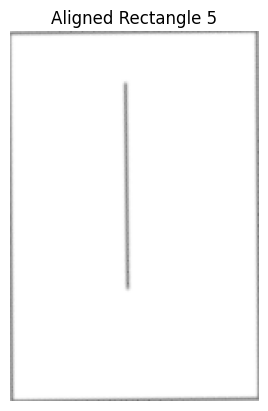

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Load image
image = cv2.imread('image.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find all contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

aligned_rectangles = []

for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        pts = approx.reshape(4, 2)
        warped = four_point_transform(image, pts)
        
        # Make vertical: rotate if width > height
        h, w = warped.shape[:2]
        if w > h:
            # Rotate 90 degrees clockwise
            warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        
        aligned_rectangles.append(warped)

# Display each aligned rectangle separately
for i, rect_img in enumerate(aligned_rectangles):
    # Save the image
    cv2.imwrite(f'aligned_rectangle_{i+1}.png', rect_img)
    
    # Display the image
    plt.figure()
    plt.title(f'Aligned Rectangle {i+1}')
    plt.imshow(cv2.cvtColor(rect_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

